In [4]:
from __future__ import division
from math import *
import numpy as np
import scipy as sp
from scipy import stats, linalg
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree



# Exploratory Analysis

In [5]:
df = pd.read_csv('datasets/conversion_data.csv')
#df.select_dtypes(include=['object'])
#df.describe(include=['object'])
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [3]:
df.head(10)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0
6,China,27,1,Seo,4,0
7,US,23,0,Ads,4,0
8,UK,29,0,Direct,4,0
9,US,25,0,Ads,2,0


In [4]:
print df.groupby('source').size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64


In [5]:
df['country'].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
dtype: int64

A few observations:
- the main user base is in US, although Chinese users are large in number
- the users are pretty young
- conversion rate is 3% which is industry standard
- everything makes sense except the age of 123! 

In [6]:
print sorted(df.age, reverse=True)[:20]

[123, 111, 79, 77, 73, 72, 70, 70, 69, 69, 69, 68, 68, 68, 68, 68, 67, 67, 67, 67]


In [5]:
df[df.age>79]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two users with unrealistic data. In this case we can remove them without losing anything. 

In [6]:
df = df[df.age<80]

Now, let's quickly investigate the variables and their distributions for each of the two classes.

converted
0    [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
1    [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
dtype: object

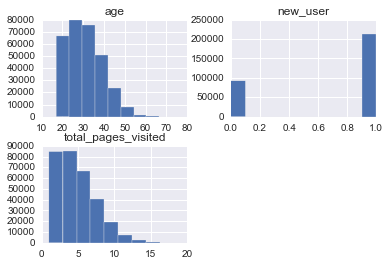

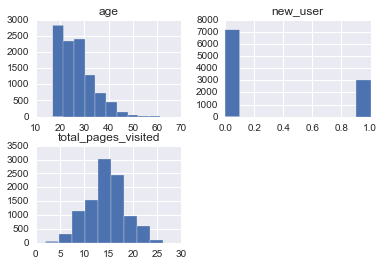

In [9]:
df.groupby('converted').hist()

A few observations:
- majority of converted users are not returning users.
- the search of converted user is more targeted based on the distribution of number of visiting pages, while non-convering users browse a few pages and leave. 

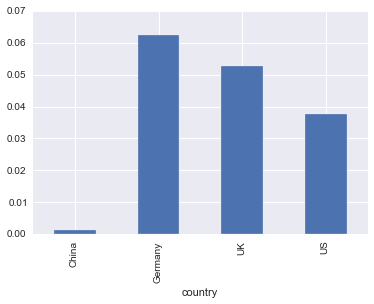

In [16]:
#df[df.converted==0]['country'].value_counts().plot(kind='bar')
df.groupby('country')['converted'].aggregate(np.mean).plot(kind='bar')

In [13]:
# another way
df.groupby(['country','converted']).aggregate(len).iloc[:,0]

country  converted
China    0             76500
         1               102
Germany  0             12240
         1               815
UK       0             45900
         1              2549
US       0            171360
         1              6732
Name: age, dtype: int64

It shows that Chinese convert at a much lower rate

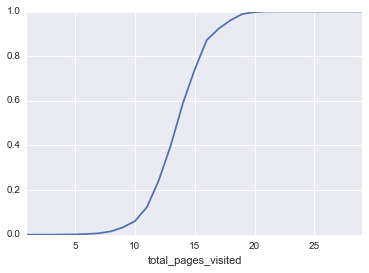

In [18]:
df.groupby('total_pages_visited')['converted'].aggregate(np.mean).plot(kind='line')

Spending more time on the site implies higher probability of conversion! 

# Machine Learning

In [7]:
df.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [8]:
le = preprocessing.LabelEncoder()
le.fit(np.unique(df['country']))
df['country']=df['country'].map(lambda x:le.transform(x))

In [9]:
le.fit(np.unique(df['source']))
df['source']=df['source'].map(lambda x:le.transform(x))

In [10]:
#pd.get_dummies(df)
df.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


Using LabelEncoder categorical data are now numbers only, and SKlearn RF classifier does not treat them different than numerical currently, but it tends to be robust in practice. Proper categorical handling is a future imporvement to SKlean RF. R handles categorical in a more natural way.

In [11]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.34, random_state=0)

clf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
clf.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

I chose 3 as number of features at each split 3, default is sqrt(#features) which is also fine. Also the out-of-bag score calculation is enabled to estimate generalization accuracy. Check out this example for out of bag error evaluation:

http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py


In [12]:
conf_mat_train = confusion_matrix(Y_train, clf.predict(X_train))
conf_mat_train

array([[201337,    586],
       [  1786,   4981]])

In [102]:
conf_mat_test = confusion_matrix(Y_test, clf.predict(X_test))
conf_mat_test

array([[103536,    541],
       [  1098,   2333]])

In [103]:
print classification_report(Y_train, clf.predict(X_train))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    201923
          1       0.90      0.73      0.81      6767

avg / total       0.99      0.99      0.99    208690



In [104]:
print classification_report(Y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    104077
          1       0.81      0.68      0.74      3431

avg / total       0.98      0.98      0.98    107508



In [111]:
random_accuracy = 100*(1-len(np.where(Y_test==1)[0])/Y_test.shape[0])
print random_accuracy

# out-of-bag training accuracy rate
print 100*clf.oob_score_

# test accuracy rate
print 100*(conf_mat_test[0,0]+conf_mat_test[1,1])/(Y_test.shape[0])


96.8086095918
98.462312521
98.4754622912


Looking at accuracy, recall, and precision scores of test and OOB, we are confident about not overfitting. Also we stareted from accuracy of %96.8 (random), so %98.5 accuracy seems good. Given more time and with fine-tuning the classifier using cross validation, even higher classification scores are possible.

# Extracting Insights from Model

Now that we built a relatively good model, we want to check on variable importances and partial dependence plots for the variables.

In [124]:
print clf.feature_importances_
print
print X.columns

[ 0.05179889  0.1100306   0.03674362  0.02631264  0.77511425]

Index([u'country', u'age', u'new_user', u'source', u'total_pages_visited'], dtype='object')


It seems that total_pages_visited is by far the most important feature. However, there is not much action to take from this insight. People who want to buy stuff visit many pages naturally. In order to find the second best variable, let's build the model again vithout this feature.

In [19]:
X = df.iloc[:,:-2]
Y = df.iloc[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.34, random_state=0)

clf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [20]:
print confusion_matrix(Y_train, clf.predict(X_train))
print
print confusion_matrix(Y_test, clf.predict(X_test))


[[201923      0]
 [  6767      0]]

[[104077      0]
 [  3431      0]]


Since we removed the most powerful variable, and the classes are highly imbalanced, we are not getting any sample classified as 1. Let's change the class weights a bit to see if things get better.   

In [24]:
clf = RandomForestClassifier(n_estimators=100, max_features=3, 
                             oob_score=True, class_weight={1:15})
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 15}, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [25]:
conf_mat_train = confusion_matrix(Y_train, clf.predict(X_train))
print conf_mat_train
print
conf_mat_test = confusion_matrix(Y_test, clf.predict(X_test))
print conf_mat_test

[[173604  28319]
 [  2834   3933]]

[[89581 14496]
 [ 1490  1941]]


In [26]:
# out-of-bag training accuracy rate
print 100*clf.oob_score_

# test accuracy rate
print 100*(conf_mat_test[0,0]+conf_mat_test[1,1])/(Y_test.shape[0])


84.8291724568
85.1304088998


Accuracy went down but it's fine. The model is still good enough for insight.

In [27]:
print clf.feature_importances_
print
print X.columns

[ 0.30020235  0.21992963  0.45429     0.02557801]

Index([u'country', u'age', u'new_user', u'source'], dtype='object')


Interesting. New user is the most important one, and the source does not seem to matter at all.

Now that we realized the level of importance of features, we want to know how exactly these features are affecting the outcome. For instance, not that we know new_user is the most important features among the 4, does it has a positive effect on the conversion, or a negative effect? The best way is by drawing Partial Dependence Plots, but unfortunately Scikit-Learn implementation of RandomForestClassifier does not provide this feature. One way to get a very broad idea on dependence of target on features is just   

In [44]:
corr_coeff(np.array(X['new_user']),np.array(Y))

-0.15233822833137906

so new users are worse.

Given more time, I would try on GradientBoostingClassifire() which provides partial dependence plots on varaiables, similar to this example:

http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html

In [46]:
clf_tree = tree.DecisionTreeClassifier(max_depth=3, class_weight={1:15})

In [47]:
clf_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight={1: 15}, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [53]:
clf_tree.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [97]:
clf_tree.tree_.threshold

array([  0.5,   0.5,  35.5,  -2. ,  -2. ,  29.5,  -2. ,  -2. ,   0.5,
        33.5,  -2. ,  -2. ,  24.5,  -2. ,  -2. ])

In [ ]:
plt.plot(ads,rho,'b--',label='rho')
plt.plot(ads,pval,'r--',label='pvalue')
plt.legend()